# Support Vector Machines from scratch

In [143]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxmat
from cvxopt import solvers as solver
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [144]:
def generate_data(n_samples=200, n_features=2, centers=2, center_box=(-15, 15), cluster_std=1):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      center_box=center_box, cluster_std=cluster_std)
    y[y == 0] = -1 
    y = y.astype(float)
    
    st = StandardScaler()
    X_s = st.fit_transform(X)
    return X_s, y

In [145]:
X, y = generate_data()

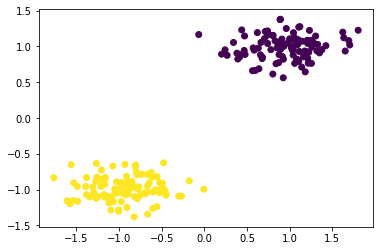

In [146]:
plt.scatter(X[:, 0], X[:, 1], c=y)

$$
    \large
    \boldsymbol{K}_{ij} = \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j)
$$

$$
    \large
    \max_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{K}_{ij} \\
    \large
    \min_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{K}_{ij} -  \sum_{i=1}^{N}\sigma_i  
$$


$$
\large
    P_{ij} = y_i y_j \boldsymbol{K}_{ij}
$$

$$
    \large
    \boldsymbol{w} = \sum_{i=1}^{N} y_i \sigma_i\phi(\boldsymbol{x}_i)
$$

$$
    \large
    b = y_s - \sum_{m \in S} \sigma_m y_m \phi(\boldsymbol{x}_m)^\top \phi(\boldsymbol{x}_s) \\
    \text{where} \; S \; \text{is the set of support vectors such as} \; \sigma_i > 0
$$

- Compute $\boldsymbol{P}$.
- Compute $\boldsymbol{w}$.
- Find the support vectors $S$ by finding any data point where $\sigma_i > 0$.
- Compute $b$.
- To predict, compute:
$$
    \large
    y_{test} = \text{sign}\left(\boldsymbol{w}^\top \phi({\boldsymbol{x}_{test}}) + b \right)
$$

CVXOPT form:
$$
    \min \frac{1}{2} \boldsymbol{x}^\top\boldsymbol{P}\boldsymbol{x} + \boldsymbol{q}^\top\boldsymbol{x}\\
    \text{s.t.} \\
    \boldsymbol{G}\boldsymbol{x} \leq h \\
    \boldsymbol{A}\boldsymbol{x} = 0
$$

In matrix form the dual optimization is:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

In [147]:
def linear_kernel(X_1, X_2):
    return np.dot(X_1, X_2)

In [210]:
class SupportVectorClassifier():
    def __init__(self, kernel, C=None):
        self.kernel = kernel
        self.C = C
        
    def fit(self, X, y):
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)
        y = y.astype(float)
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i, :], X[j, :])
        q = cvxmat(np.ones((n_samples, 1)) * -1.)
        A = cvxmat(y.T)
        b = cvxmat(0.)
        P = cvxmat(np.outer(y, y) * K)
        
        if self.C is None:
            G = cvxmat(np.eye(n_samples) * -1.)
            h = cvxmat(np.zeros((n_samples, 1)))
        else:
            col_1 = np.eye(n_samples) * -1.
            col_2 = np.identity(n_samples)
            G = cvxmat(np.vstack((col_1, col_2)))
            
            col_1 = np.zeros(n_samples)
            col_2 = np.ones(n_samples) * self.C
            h = cvxmat(np.hstack((col_1, col_2)))
        
        sigma = np.array(solver.qp(P, q, G, h, A, b)['x'])
        
        sv_idx = sigma > 1e-5
        self.sv_sigma = np.expand_dims(sigma[sv_idx], axis=1)
        sv_idx = np.squeeze(sv_idx)
        self.sv = X[sv_idx, :]
        self.sv_y = y[sv_idx]
       
        if self.kernel == linear_kernel:
            w = np.sum(self.sv_y * self.sv_sigma * self.sv, axis=0)
            self.w = np.expand_dims(w, axis=1)
        else:
            self.w = None
        
        # Gather all pairwise distance of the support vectors
        idx = sv_idx.astype(int).nonzero()[0]
        b = 0
        sv_sigma_flat = self.sv_sigma.flatten()
        sv_y_flat = self.sv_y.flatten()
        for i in range(len(idx)):
            b += self.sv_y[i]
            b -= np.sum(sv_sigma_flat * sv_y_flat * K[idx[i], sv_idx])
        b /= len(idx)
        self.b = b
        
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            pred = np.zeros(X.shape[0])
            for i in range(X.shape[0]):
                cur_pred = 0
                for j in range(self.sv_sigma.shape[0]):
                    cur_pred += self.sv_sigma[j] * self.sv_y[j] * self.kernel(X[i], self.sv[j])
                pred[i] = cur_pred
            return pred + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))

In [211]:
svc = SupportVectorClassifier(linear_kernel)
svc.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -1.6591e+02 -3.9116e+02  2e+02  4e-14  2e+00
 1: -3.5588e+02 -3.6335e+02  7e+00  5e-15  1e+00
 2: -1.7374e+04 -1.7380e+04  6e+00  7e-12  1e+00
 3: -5.0598e+07 -5.0598e+07  2e+02  1e-08  1e+00
 4: -5.4654e+10 -5.4655e+10  2e+05  2e-05  1e+00
Terminated (singular KKT matrix).


In [150]:
pred = svc.predict(X)

In [151]:
def f(x, w, b):
    return (-w[0] * x - b) / w[1]

In [152]:
def plot_svc(X, y, svc, pred, plot_sv=True):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if plot_sv:
        plt.scatter(svc.sv[:, 0], svc.sv[:, 1])
    axis_min, axis_max = plt.gca().get_xlim()
    
    w = svc.w
    
    a = -w[0] / w[1]
    xx = np.linspace(axis_min, axis_max)
    yy = a * xx - svc.b[0] / w[1]

    # Plot the hyperplane
    b = svc.sv[np.where(svc.sv_y == 1.)[0]][0]
    
    yy_down = a * xx + (b[1] - a * b[0])
    b = svc.sv[np.where(svc.sv_y == -1.)[0]][0]
    yy_up = a * xx + (b[1] - a * b[0])
    
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

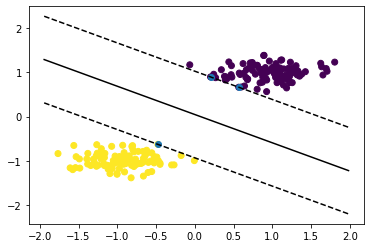

In [153]:
plot_svc(X, y, svc, pred)

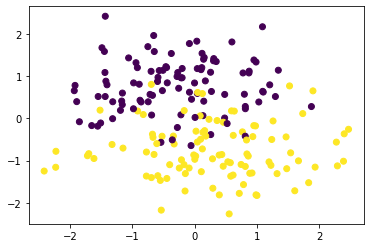

In [157]:
X, y = generate_data(n_samples=200, n_features=2, centers=2, center_box=(-5, 5), cluster_std=2.5)
plt.scatter(X[:, 0], X[:, 1], c=y)

$$
\begin{align}
    &\max_{\boldsymbol{\sigma}}\sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \phi(\boldsymbol{x}_i)^\top \phi(\boldsymbol{x}_j) \\
    &\text{s.t.} \quad 0 \leq \sigma_i \leq C && \forall i \in \{1, \dots, N\}\\
    &\text{s.t.} \quad \sum_{i=1}^{N}\sigma_iy_i = 0 && \forall i \in \{1, \dots, N\}\\
\end{align}
$$

$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \sigma_i \leq C \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

In [159]:
svc_soft = SupportVectorClassifier(linear_kernel, C=0.1)

     pcost       dcost       gap    pres   dres
 0: -4.2577e+01 -4.1240e+01  1e+03  3e+01  2e-15
 1: -7.5598e+00 -3.8621e+01  9e+01  1e+00  1e-15
 2: -5.1212e+00 -1.8202e+01  1e+01  3e-02  1e-15
 3: -6.0958e+00 -8.1423e+00  2e+00  4e-03  7e-16
 4: -6.7688e+00 -7.1911e+00  4e-01  5e-04  5e-16
 5: -6.8928e+00 -7.0247e+00  1e-01  1e-04  5e-16
 6: -6.9357e+00 -6.9653e+00  3e-02  2e-05  6e-16
 7: -6.9460e+00 -6.9522e+00  6e-03  3e-06  5e-16
 8: -6.9488e+00 -6.9489e+00  9e-05  4e-08  6e-16
 9: -6.9489e+00 -6.9489e+00  9e-07  4e-10  6e-16
Optimal solution found.


In [160]:
pred = svc_soft.predict(X)

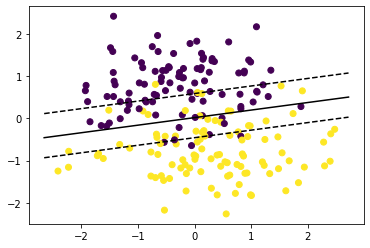

In [161]:
plot_svc(X, y, svc_soft, pred, plot_sv=False)

In [186]:
def generate_non_linear(mean_1, mean_2, mean_3, mean_4, cov):
    X_1 = np.random.multivariate_normal(mean_1, cov, 50)
    X_1 = np.vstack((X_1, np.random.multivariate_normal(mean_3, cov, 50)))
    y_1 = np.ones(len(X_1))
    X_2 = np.random.multivariate_normal(mean_2, cov, 50)
    X_2 = np.vstack((X_2, np.random.multivariate_normal(mean_4, cov, 50)))
    y_2 = np.ones(len(X_2)) * -1
    
    X = np.vstack([X_1, X_2])
    y = np.hstack([y_1, y_2])
    X = StandardScaler().fit_transform(X)
    return X, y

In [194]:
X, y = generate_non_linear(mean_1=[-2, 2], mean_2=[1, -1],
                           mean_3=[4, -4], mean_4=[-4, 4],
                           cov=[[1.0,0.8], [0.8, 1.0]])

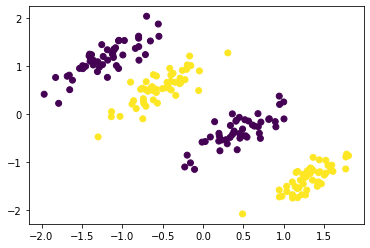

In [195]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [196]:
def polynomial_kernel(X_1, X_2, p):
    return (1 + np.dot(X_1, X_2)) ** p

def gaussian_kernel(X_1, X_2, sigma=5.0):
    return np.exp(-np.linalg.norm(X_1 - X_2) ** 2 / (2 * sigma ** 2))

In [212]:
svc_gauss = SupportVectorClassifier(gaussian_kernel)
svc_gauss.fit(X, y)

     pcost       dcost       gap    pres   dres
 0: -1.6821e+02 -3.9346e+02  2e+02  1e-14  2e+00
 1: -3.5571e+02 -3.9575e+02  4e+01  5e-14  1e+00
 2: -1.7654e+03 -1.9117e+03  1e+02  5e-14  1e+00
 3: -3.6111e+03 -3.9068e+03  3e+02  7e-13  1e+00
 4: -8.0460e+03 -8.7235e+03  7e+02  2e-12  1e+00
 5: -1.9881e+04 -2.2001e+04  2e+03  4e-12  1e+00
 6: -4.5446e+04 -5.1299e+04  6e+03  1e-11  1e+00
 7: -1.0410e+05 -1.2172e+05  2e+04  2e-11  9e-01
 8: -1.6669e+05 -2.0043e+05  3e+04  6e-12  7e-01
 9: -2.1518e+05 -2.5289e+05  4e+04  2e-10  4e-01
10: -2.3293e+05 -2.4995e+05  2e+04  9e-11  1e-01
11: -2.3616e+05 -2.3666e+05  5e+02  9e-11  2e-03
12: -2.3626e+05 -2.3627e+05  5e+00  2e-10  2e-05
13: -2.3626e+05 -2.3626e+05  5e-02  4e-11  2e-07
14: -2.3626e+05 -2.3626e+05  5e-04  1e-10  2e-09
Optimal solution found.


In [213]:
svc_gauss.predict(X)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [209]:
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1